# Computing galaxy-galaxy-galaxy lensing statistics

In this notebooks we compute the galaxy-galaxy-galaxy lensing (G3L) shear correlation functions on a mock catalog and transform them to the third-order aperture statistics.

In [1]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt

import orpheus

## Initialize the catalog instances

For this exercise we use a simplistic mock catalog that traces a euclid-like setup for the n(z) and uses a linear galaxy bias. In order to keep the computation time low, we focus on a single tile and further only look at some tomographic redshift bin combination. 

As we are dealing with two separate catalogs, we need to initialize a `ScalarTracerCatalog` instance for the lenses and a `SpinTracerCatalog` (with `spin=2`) for the sources.

In [2]:
path_to_data = "/vol/euclidraid4/data/lporth/Projects/G3LEstimators/data/GLASS/mocks/euclidlike_fromT17_fullsky/patches/nside8192_real0_patch129.npz"

In [3]:
mock = np.load(path_to_data)

In [4]:
sel_lens = (mock["zbin"] == 2) * mock["isinner"]
sel_source = (mock["zbin"] == 7) * mock["isinner"]

In [5]:
fthin_lens = 2
fthin_source = 1
sel_lens = mock["zbin"] == 2
sel_source = mock["zbin"] == 7
sources = orpheus.SpinTracerCatalog(spin=2,
                                    pos1=mock["x"][sel_source][::fthin_source], 
                                    pos2=mock["y"][sel_source][::fthin_source],
                                    tracer_1=mock["gam1"][sel_source][::fthin_source],
                                    tracer_2=mock["gam2"][sel_source][::fthin_source], 
                                    isinner=mock["isinner"][sel_source][::fthin_source],
                                    weight=None, zbins=None)
lenses = orpheus.ScalarTracerCatalog(pos1=mock["x"][sel_lens][::fthin_lens], 
                                     pos2=mock["y"][sel_lens][::fthin_lens], 
                                     tracer=np.ones_like(mock["x"][sel_lens][::fthin_lens]), 
                                     isinner=mock["isinner"][sel_lens][::fthin_lens],
                                     weight=None, zbins=None)

In [6]:
print("Number of source galaxies:%i --> effective nbar: %.3f/arcmin^2 on %.2f deg^2"%(
    sources.ngal, sources.ngal/(sources.len1*sources.len2), sources.len1*sources.len2/3600.))
print("Number of lens galaxies:%i --> effective nbar: %.3f/arcmin^2 on %.2f deg^2"%(
    lenses.ngal, lenses.ngal/(lenses.len1*lenses.len2), lenses.len1*lenses.len2/3600.))

Number of source galaxies:2982910 --> effective nbar: 2.721/arcmin^2 on 304.50 deg^2
Number of lens galaxies:1508628 --> effective nbar: 1.376/arcmin^2 on 304.45 deg^2


## Computation of the shear-lens-lens correlation function

For computing the shear-lens-lens correlation function we need to invoke the `GNNCorrelation` class. In principle, it is only required to define a binning for the 3pcf (given by the range of the bins and the number of bins).

**Notes**

* Instead of the number of bins you can also specify the logarithmic bin-width `binsize`. However, the final value of `binsize` might differ slightly from the provided one as we fix the values for the binning range and then choose the largest possible value of `binsize` that is smaller or equal to the input value for `binsize`.

* If no further parameters are passed, the default setup chooses the some accelerations of the discrete multipole estimator renders fairly accurate results for the 3pcf itself and percent-level accuracy for the third-order aperture statistics. In case you want a different setup than the default results you can change the parameters of the parent `BinnedNPCF` class.

In [7]:
min_sep = 0.25
max_sep = 150.
binsize = 0.1
nbinsphi = 256
method = "DoubleTree"
resoshift_leafs=-2
nthreads = 64

gnn = orpheus.GNNCorrelation(min_sep=min_sep, 
                                 max_sep=max_sep, 
                                 binsize=binsize,
                                 nbinsphi=nbinsphi,
                                 method=method,
                                 resoshift_leafs=resoshift_leafs,
                                 nthreads=nthreads)

<CDLL '/vol/euclidraid4/data/lporth/HigherOrderLensing/Estimator/orpheus/orpheus/src/discrete.so', handle 561ba90 at 0x7fe7cb51ce60>


In [8]:
%%time
gnn.process(sources, lenses)

Region 126997 is in thread 32
Bin edges:
  reso=0: index_start=0, rtarget_start=0.25, rtrue_start=0.25
           index_end=30, rtarget_end=5.00, rtrue_end=5.01
  reso=1: index_start=30, rtarget_start=5.00, rtrue_start=5.01
           index_end=37, rtarget_end=10.00, rtrue_end=10.09
  reso=2: index_start=37, rtarget_start=10.00, rtrue_start=10.09
           index_end=44, rtarget_end=20.00, rtrue_end=20.32
  reso=3: index_start=44, rtarget_start=20.00, rtrue_start=20.32
           index_end=51, rtarget_end=40.00, rtrue_end=40.91
  reso=4: index_start=51, rtarget_start=40.00, rtrue_start=40.91
           index_end=64, rtarget_end=150.00, rtrue_end=150.00
ngal_in_pix[elreso=0][elz=0] = 16 
matchers_resoshift[elreso=0] = 0 
ngal_in_pix[elreso=1][elz=0] = 16 
matchers_resoshift[elreso=1] = 64 
ngal_in_pix[elreso=2][elz=0] = 12 
matchers_resoshift[elreso=2] = 80 
ngal_in_pix[elreso=3][elz=0] = 4 
matchers_resoshift[elreso=3] = 84 
ngal_in_pix[elreso=4][elz=0] = 1 
matchers_resoshift[elreso=4

Once processed, the instance of `GNNCorrelation` contains the multipole components of the shear-lens-lens correlators $\Upsilon^{'}_{\tilde{\mathcal{G}},n}$, as well as their nonrmalizations $\mathcal{W}_n$ in their multipole basis. If required, we can use the `multiples2npcf` method to transform the to the real-space basis, in which they become the more well-known shear-lens-lens correlation function $\tilde{G}$ (Schneider & Watts 2005).

In [9]:
%%time
gnn.multipoles2npcf()

CPU times: user 474 ms, sys: 12 ms, total: 486 ms
Wall time: 482 ms


## Computation of the aperture mass

The integral transormation between the shear-lens-lens 3PCF and their third-order aperture statistics can be done by calling the `GNNNCorrelation.computeNNM` method.

**Notes**

* In case you are only interested in obtaining the third-order aperture statistics, you can also directly call this method right after processing the shape catalog.

* One should only trust the third-order aperture statistics for radii $R\in[\alpha\,\theta_{\rm min}, \beta\,\theta_{\rm max}]$, where $\alpha\approx 5$  and $\beta \approx 0.125$. In the plot below this range is indicated by the dashed vertical lines.

* Furthermore, the binning should be sufficiently fine, i.e. the value of the `GNNCorrelation.binsize` attribute should be less than `0.1` for an accuracy of about one per cent.

In [10]:
%%time
radii_ap = np.geomspace(1.,30.,20)
NNM = gnn.computeNNM(radii_ap)

CPU times: user 11 s, sys: 11 s, total: 21.9 s
Wall time: 3.91 s


(1e-08, 9.72399661216892e-05)

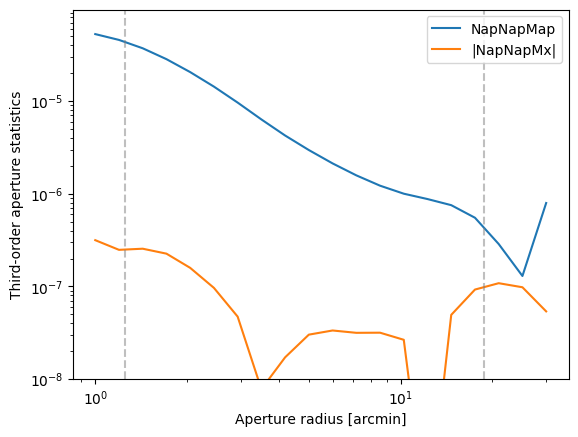

In [15]:
plt.loglog(radii_ap, NNM[0,0].real, label="NapNapMap")
plt.loglog(radii_ap, np.abs(NNM[0,0].imag), label="|NapNapMx|")
plt.axvline(x=5*gnn.min_sep, color="grey",alpha=0.5,ls="--")
plt.axvline(x=0.125*gnn.max_sep, color="grey",alpha=0.5,ls="--")
plt.xlabel("Aperture radius [arcmin]")
plt.ylabel("Third-order aperture statistics")
plt.legend(loc="upper right")
plt.ylim(1e-8,None)